<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/05%20Deep%20Learning/notebooks/9-Embeddings-NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import gensim.downloader

In [8]:
for x in gensim.downloader.info()['models'].keys():
    print(x)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [9]:
# w2v = gensim.downloader.load('word2vec-google-news-300')

In [10]:
kv = gensim.downloader.load('glove-twitter-100')


KeyboardInterrupt



También podemos buscar estos modelos en diversos sitios, por ejemplo: 

* https://github.com/RaRe-Technologies/gensim-data

Cada review se considera un documento. El corpus consiste de 50,000 docuemtnos.  Necesitamos limpiar los documentos quitando stopwords, símbolos, etc.

In [1]:
#@title Bajamos los datos de nltk 
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/wini/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/wini/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/wini/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/wini/nltk_data...


True

In [ ]:
#@title Función para limpiar el texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean(text):
    clean_text = re.sub(CLEANR, '', text.lower()) # Quitamos etiquetas HTML
    clean_text = re.sub(r'[^\w\s]', '', clean_text.lower()) # Quitamos signos de puntuación y símbolos
    clean_text = re.sub('[0-9]', '', clean_text.lower())  # Quitamos números
    SW = stopwords.words('english') # Leemos la lista de stopwords del inglés
    tokens_no_sw = [word for word in word_tokenize(clean_text) if not word in SW] # Quitamos stopwords
    stems = []
    for w in tokens_no_sw:
        stems.append(lemmatizer.lemmatize(w))
    return stems

In [ ]:
import pandas as pd

df = pd.read_csv('/content/IMDB Dataset.csv')
display(df.sample(5))

,review,sentiment
47521,"There has never been anything like it, that's ...",positive
10512,"I was very concerned about this film, it was s...",negative
8918,Christian Duguay directed this tidy little esp...,positive
42036,I've known about Bettie Page for many a year n...,positive
49460,I would like to comment on the movie April Lov...,positive


In [ ]:
df['clean'] = df['review'].apply(clean)
df.sample(5)

,review,sentiment,clean
4608,I have seen this movie and in all honestly was...,negative,"[seen, movie, honestly, quite, disappointed, o..."
46000,Surviving Christmas is a surprisingly funny mo...,positive,"[surviving, christmas, surprisingly, funny, mo..."
42679,"Narratives  whether written, visual or poetic...",positive,"[narrative, whether, written, visual, poetic, ..."
48021,I really don't know much about the Marquis de ...,negative,"[really, dont, know, much, marquis, de, sade, ..."
44095,"In 1914, Charlie Chaplin began making pictures...",negative,"[charlie, chaplin, began, making, picture, mad..."


In [2]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("data/word2vec.model")
keyed_vectors = w2v_model.wv

embedding_dim = keyed_vectors.vector_size

print(embedding_dim)

100


Obtengamos el vocabulario

In [3]:
import numpy as np

vocab = list(keyed_vectors.key_to_index)
n_words = len(vocab)

print(f"Longitud del vocabulario: {n_words}")

Longitud del vocabulario: 12256


In [4]:
import pandas as pd
from tensorflow.keras.utils import to_categorical

msjs_df = pd.read_csv("data/sms_full_dataframe.csv",index_col=0)
msjs_df['Normalized Label'] = (2/5)*msjs_df['ds'].values-1
y = msjs_df['ds'].values

y = to_categorical(y, num_classes=6)

print(y[:6])

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


### LSTM

Ahora, realizaremos la clasificación usando una red con una capa LSTM. Repetiremos la estrategia de la sesión pasada, pero ahora incorporaremos los embeddings que acabamos de calcular

In [5]:
from sklearn.model_selection import train_test_split

reviews = msjs_df['Texto'].values

train_reviews, test_reviews, y_train, y_test = train_test_split(reviews, y, train_size=0.85, random_state=74)

print(f"Shape of X_train: {train_reviews.shape}")
print(f"Shape of X_test: {test_reviews.shape}")

Shape of X_train: (4665,)
Shape of X_test: (824,)


Tokenizamos los documentos para obtener las secuencias de índices

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ----- Hiperparámetros para este preprocesamiento
vocab_size = 10000   # Nos limitaremos a ese número de palabras del vocabulario
oov_tok = ''        # Las palabras fuera del vocabulario se reemplazarán con este string
max_length = 100    # La longitud común deseada para las secuencias al hacer el padding

#  ----- Entrenamos el tokenizador 
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_reviews)

#  ----- Creamos las secuencias de entrenamiento y hacemos el padding
train_sequences = tokenizer.texts_to_sequences(train_reviews)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

#  ----- Creamos las secuencias de prueba y hacemos el padding
test_sequences = tokenizer.texts_to_sequences(test_reviews)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

Usar nuestras representaciones en la capa de embeddings

In [13]:
from scoring import Scoring
from keras.layers import Embedding

W0_dict = pd.read_pickle("data/palabras_auto.pickle")

msjs_df = pd.read_csv("data/sms_full_dataframe.csv",index_col=0)
msjs_df['Normalized Label'] = (2/5)*msjs_df['ds'].values-1
puntaje = Scoring(w2vmodel=w2v_model,W0=W0_dict)
puntaje.build_neighbors(alpha=0.65)
scores_df = puntaje.transform(df=msjs_df,text_col="Texto",label_col="Normalized Label",beta1=0.5,beta2=5.5)
W0_dict = dict(zip(scores_df['word'].values,scores_df['score'].values))
word_representations = puntaje.get_words_representations(mode='mean')

embedding_dim = keyed_vectors.vector_size
vocab_len = len(vocab)
embedding_matrix = np.zeros((vocab_len, embedding_dim))

for word, index in tokenizer.word_index.items():
    try:
        if word in vocab:
            idx = vocab.index(word)
        embedding_matrix[index, :] = word_representations[idx,:]
    except:
        pass

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embedding_dim, input_length=max_length, 
                            weights = [embedding_matrix], trainable=False)

Preparamos la capa Embedding, ahora en lugar de generar embeddings, sólo los recuperará de nuestro embeddings entrenados

In [12]:
from keras.layers import Embedding

vocab_len = len(vocab)

embedding_matrix = np.zeros((vocab_len, embedding_dim))

for word, index in tokenizer.word_index.items():
    try:
        embedding_vector = w2v_model.wv.get_vector(word)
        if embedding_vector is not None:
            embedding_matrix[index, :] = embedding_vector
    except:
        pass

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embedding_dim, input_length=max_length, 
                            weights = [embedding_matrix], trainable=True)

Esta capa de embeddings se incorpora a la arquitectura de la red

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# ----- model initialization
model = Sequential([
    embedding_layer,
    LSTM(64, dropout=0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(6, activation='softmax')
])

# ----- compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1225600   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                                 
Total params: 1,270,550
Trainable params: 44,950
Non-trainable params: 1,225,600
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=3)

num_epochs = 25

history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)#,
                    # callbacks=[es])

Epoch 1/25
132/132 [==============================] - 6s 36ms/step - loss: 0.4386 - accuracy: 0.3821 - val_loss: 0.3874 - val_accuracy: 0.4775
Epoch 2/25
132/132 [==============================] - 4s 33ms/step - loss: 0.3925 - accuracy: 0.4609 - val_loss: 0.3885 - val_accuracy: 0.4775
Epoch 3/25
132/132 [==============================] - 4s 33ms/step - loss: 0.3930 - accuracy: 0.4609 - val_loss: 0.3886 - val_accuracy: 0.4775
Epoch 4/25
132/132 [==============================] - 4s 34ms/step - loss: 0.3927 - accuracy: 0.4609 - val_loss: 0.3881 - val_accuracy: 0.4775
Epoch 5/25
132/132 [==============================] - 4s 33ms/step - loss: 0.3928 - accuracy: 0.4609 - val_loss: 0.3877 - val_accuracy: 0.4775
Epoch 6/25
132/132 [==============================] - 4s 33ms/step - loss: 0.3928 - accuracy: 0.4609 - val_loss: 0.3876 - val_accuracy: 0.4775
Epoch 7/25
132/132 [==============================] - 4s 33ms/step - loss: 0.3928 - accuracy: 0.4609 - val_loss: 0.3881 - val_accuracy: 0.4775

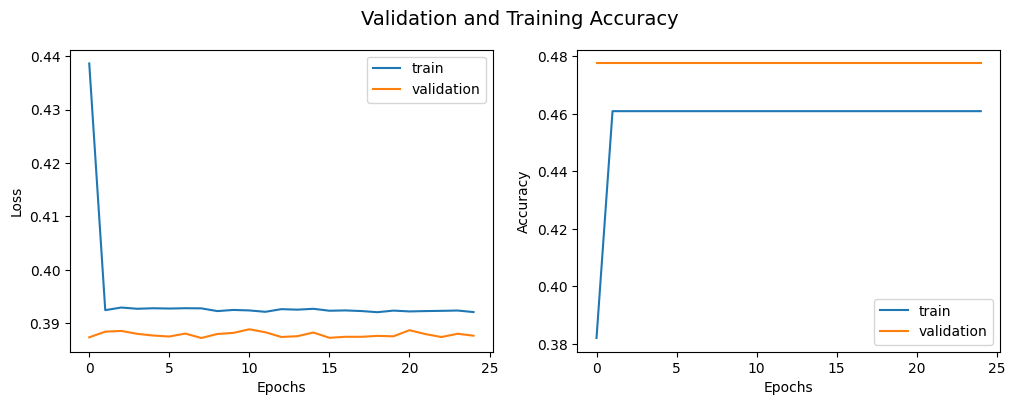

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4),dpi=100)
plt.suptitle("Training Curves",fontsize=16)
plt.subplot(1, 2, 1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.subplot(1, 2, 2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Recuperar nuevos embeddings

In [11]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

predictions = model.predict(test_padded)

pred_labels = []

for x in predictions:
    if x >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)

test_accuracy = accuracy_score(y_test,pred_labels)
test_recall = recall_score(y_test,pred_labels)
print(f"Test Accuracy: {round(test_accuracy,3)}")
print(f"Test Recall: {round(test_recall,3)}")

print("\nConfusion Matrix:\n",confusion_matrix(y_test,pred_labels))

26/26 [==============================] - 1s 12ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()